**Step 3: Remove leap days via convert_calendar and add `dayofyear` coodinate to yearly files. Convert netcdf files to zarr stores.**

In [ ]:
! pip install xclim 

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 

import intake
import zarr
import gcsfs

#import dask
#import dask.array as da
#import dask.distributed as dd
#import rhg_compute_tools.kubernetes as rhgk

from xclim.core.calendar import convert_calendar

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Use a large notebook and compute all within notebook memory. Otherwise dask workers fail.

In [ ]:
client, cluster = rhgk.get_big_cluster()
cluster.scale(30)

In [ ]:
client

In [ ]:
cluster.close()

For bias correction, we will be using 1995-2014 (the CMIP6 reference period). 1994 & 2015 are needed for extra 15 days.

In [ ]:
years = np.arange(1994, 2016)

In [2]:
fs = gcsfs.GCSFileSystem(token='/opt/gcsfuse_tokens/impactlab-data.json')

In [ ]:
# Provide `dayofyear` coordinate to data. Needs to be in full years
def assign_dayofyear_coord(da):
    
    years = np.arange(da.time.dt.year.min(),da.time.dt.year.max()+1)
    da_wcoords = da.assign_coords(dayofyear=xr.DataArray(np.array([np.arange(1,366)]*len(years)).flatten(),
                                                dims=('time'),
                                                coords={'time':da.time})).persist()
    return da_wcoords

Temperature and DTR zarr stores were created using this function

In [ ]:
def create_era5_zarr_store(variable, years): 
    
    # create list of filenames to load
    filenames = [os.path.join('/gcs/impactlab-data/climate/source_data/ERA-5/%s/daily/netcdf/v1.3' %variable, 
                          '%s_daily_%s-%s.nc' %(variable, year, year)) for year in years]
    
    # Load files for specified years, note that the `preprocess=convert_to_noleap_calendar` argument is 
    # removing leap days and updating the calendar on each yearly file of daily data as it's being concatenated
    ds_allyears = xr.open_mfdataset(filenames,
                               concat_dim='time', combine='by_coords') 
    
    # remove leap days and convert calendar to no-leap    
    ds_allyears = convert_calendar(ds_allyears, 'noleap')
    
    # assign day of year coordinate on full years
    ds_allyears = assign_dayofyear_coord(ds_allyears)
    
    store_filename = 'gs://impactlab-data/climate/source_data/ERA-5/downscaling/%s.1994-2015.F320.v3.zarr' %variable 
    store = fs.get_mapper(store_filename, check=False)
    
    # for precip, convert from m/day to mm/day
    if variable == pr:
        da_mm = ds_allyears[variable]*1000
        da_mm.attrs["units"] = "mm/day"
    
        attrsdt = {'method': 'Changed calendar to no-leap, removed leap days, converted to mm/day'}
        da_mm.attrs.update(attrsdt)
        da_mm.to_zarr(store, consolidated=True, mode="w")
        
        # save a second zarr store with the wet day frequency correction
        da_wdf = apply_wet_day_frequency_correction(da_mm, "pre")
        attrsdt = {'method': 'Changed calendar to no-leap, removed leap days, converted to mm/day, wet day frequency correction applied'}
        da_wdf.attrs.update(attrsdt)
        
        store_filename = 'gs://impactlab-data/climate/source_data/ERA-5/downscaling/%s.1994-2015.F320.wdf_corr.zarr' %variable
        store = fs.get_mapper(store_filename, check=False)
        da_wdf.to_zarr(store, consolidated=True, mode="w")
    # for all other variables, create a single zarr store    
    else:
        attrsdt = {'method': 'Changed calendar to no-leap and removed leap days'}
        ds_allyears.attrs.update(attrsdt)
    
        #if not fs.exists(store_filename): 
            # save as a zarr store for rechunking 
        ds_allyears.to_zarr(store, consolidated=True, mode="w")

In [ ]:
era5_variables = ['tasmax', 'tasmin', 'dtr']

create zarr stores for tmax, tmin and dtr

In [ ]:
for variable in era5_variables: 
    create_era5_zarr_store(variable, years)

If creating the zarr store kills workers (i.e., precip), follow the steps below to first load & process the data, then load the ds before saving as a zarr store. 

In [ ]:
def create_era5(variable, years): 
    
    # create list of filenames to load
    filenames = [os.path.join('/gcs/impactlab-data/climate/source_data/ERA-5/%s/daily/netcdf/v1.3' %variable, 
                          '%s_daily_%s-%s.nc' %(variable, year, year)) for year in years]
    
    # Load files for specified years, note that the `preprocess=convert_to_noleap_calendar` argument is 
    # removing leap days and updating the calendar on each yearly file of daily data as it's being concatenated
    ds_allyears = xr.open_mfdataset(filenames,
                               concat_dim='time', combine='by_coords')
    
    # remove leap days and convert calendar to no-leap    
    ds_allyears = convert_calendar(ds_allyears, 'noleap')
    
    # assign day of year coordinate on full years
    ds_allyears = assign_dayofyear_coord(ds_allyears)
    
    #return ds_allyears
    # for precip, convert from m/day to mm/day
    if variable == 'pr':
        da_mm = ds_allyears['tp']*1000
        da_mm.attrs["units"] = "mm/day"
        
        da_mm = da_mm.persist()
        
        # Replace negative floating point values with 0.0
        da_mm = da_mm.where(da_mm > 0.0, other=0, drop=False)
    
        attrsdt = {'method': 'Changed calendar to no-leap, removed leap days, converted to mm/day, replaced negative values with 0'}
        da_mm.attrs.update(attrsdt)
        
        return da_mm
        
    # for all other variables, create a single zarr store    
    else:
        attrsdt = {'method': 'Changed calendar to no-leap and removed leap days'}
        ds_allyears.attrs.update(attrsdt)
    
        return ds_allyears

In [ ]:
era5_variables = ['pr']

In [ ]:
for variable in era5_variables: 
    if variable == 'pr':
        da_mm = create_era5(variable, years)
    else:
        ds = create_era5(variable, years)

Must be a Dataset to create a zarr store!

In [ ]:
ds_mm = da_mm.to_dataset()

In [ ]:
store_filename = 'gs://impactlab-data/climate/source_data/ERA-5/downscaling/%s.1994-2015.F320.v5.zarr' %variable
store = fs.get_mapper(store_filename, check=False)

In [ ]:
ds_mm.to_zarr(store, consolidated=True, mode="w")

Method above might fail in notebook memory, if so compute per year with below functions.

Latest precip versions were created using the following:

In [ ]:
def create_era5_per_year(variable, year): 
    
    # create list of filenames to load
    filename = [os.path.join('/gcs/impactlab-data/climate/source_data/ERA-5/%s/daily/netcdf/v1.3' %variable, 
                          '%s_daily_%s-%s.nc' %(variable, year, year))]
    
    # Load files for specified years, note that the `preprocess=convert_to_noleap_calendar` argument is 
    # removing leap days and updating the calendar on each yearly file of daily data as it's being concatenated
    ds = xr.open_mfdataset(filename)
    
    # remove leap days and convert calendar to no-leap    
    ds = convert_calendar(ds, 'noleap')
    
    # assign day of year coordinate on full years
    ds = assign_dayofyear_coord(ds)
    
    #return ds_allyears
    # for precip, convert from m/day to mm/day
    if variable == 'pr':
        da_mm = ds['tp']*1000
        da_mm.attrs["units"] = "mm/day"
        
        # Replace negative floating point values with 0.0
        da_mm = da_mm.where(da_mm > 0.0, other=0, drop=False)
    
        attrsdt = {'method': 'Changed calendar to no-leap, removed leap days, converted to mm/day, replaced negative values with 0'}
        da_mm.attrs.update(attrsdt)
        
        da_mm = da_mm.persist()
        return da_mm
        
    # for all other variables, create a single zarr store    
    else:
        attrsdt = {'method': 'Changed calendar to no-leap and removed leap days'}
        ds.attrs.update(attrsdt)
    
        return ds

In [ ]:
def create_netcdf(ds, year):
    '''
    create netcdf file of yearly wet day frequency applied precip data .
    '''
    out_direc = ('/gcs/impactlab-data/climate/source_data/ERA-5/pr/daily/netcdf/wetdayfreq_daily_per_yr')
    out_filename = ('pr_{year}.nc').format(year=year)
            
    # add attributes to dataset and save file 
    attrsdt = {
        'author': 'Meredith Fish',
        'contact': 'meredith.fish@rutgers.edu',
        'project': ('downscaling CMIP6'),
        'source': ('/gcs/climate/source_data/ERA-5/day/tas/v1.1'),
        'created': str(date.today())}

    ds.attrs.update(attrsdt)
    
    # save file
    ds.to_netcdf(Path(PurePath(out_direc).joinpath(out_filename)))

In [ ]:
for iyrs in years:
    da_mm = create_era5_per_year('pr', iyrs)
    ds_mm = da_mm.to_dataset()
    
    create_netcdf(ds_mm, iyrs)

create a second zarr store with the wet day frequency correction

In [ ]:
# do this before importing dodola in notebook
! pip install git+https://github.com/dgergel/xsd@feature/add_spatial_disaggregation_recipe

In [ ]:
from dodola.core import apply_wet_day_frequency_correction
from datetime import date
from pathlib import Path, PurePath

In [ ]:
for iyrs in years:
    da_mm = create_era5_per_year('pr', iyrs)
    ds_mm = da_mm.to_dataset()
    
    # apply wet day frequency correction
    ds_wdf = apply_wet_day_frequency_correction(ds_mm, "pre")
    attrsdt = {'method': 'Changed calendar to no-leap, removed leap days, converted to mm/day, wet day frequency correction applied'}
    ds_wdf.attrs.update(attrsdt)
    
    create_netcdf(ds_wdf, iyrs)

Open all created netcdf files to combine for a single zarr store

In [3]:
filenames = ('/gcs/impactlab-data/climate/source_data/ERA-5/pr/daily/netcdf/wetdayfreq_daily_per_yr/pr_*.nc')
ds_allyears = xr.open_mfdataset(filenames,
                               concat_dim='time', combine='by_coords')

In [ ]:
ds_allyears = ds_allyears.load()

In [5]:
store_filename = 'gs://impactlab-data/climate/source_data/ERA-5/downscaling/pr.1994-2015.F320.wdf_corr_v2.zarr'
store = fs.get_mapper(store_filename, check=False)

In [6]:
ds_allyears.to_zarr(store, consolidated=True, mode="w")

check zarr store according to cells below.

check to be sure xarray can read one of the zarr stores

In [7]:
store_filename = 'gs://impactlab-data/climate/source_data/ERA-5/downscaling/pr.1994-2015.F320.wdf_corr_v2.zarr' 
store = fs.get_mapper(store_filename, check=False)
ds_testread = xr.open_zarr(store, consolidated=True)

In [8]:
ds_testread

<xarray.Dataset>
Dimensions:    (latitude: 640, longitude: 1280, time: 8030)
Coordinates:
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
  * latitude   (latitude) float32 89.78 89.51 89.23 ... -89.23 -89.51 -89.78
  * longitude  (longitude) float32 0.0 0.2813 0.5625 ... 359.2 359.4 359.7
  * time       (time) object 1994-01-01 00:00:00 ... 2015-12-31 00:00:00
Data variables:
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(365, 640, 1280), meta=np.ndarray>
Attributes:
    author:   Meredith Fish
    contact:  meredith.fish@rutgers.edu
    created:  2021-07-16
    method:   Changed calendar to no-leap, removed leap days, converted to mm...
    project:  downscaling CMIP6
    source:   /gcs/climate/source_data/ERA-5/day/tas/v1.1

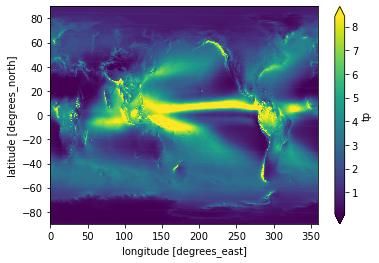

In [14]:
ds_testread['tp'].mean(dim='time').plot(robust=True)